# Imports

In [76]:
#mlops environment
import pandas as pd 
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction import DictVectorizer
import seaborn as sns
import matplotlib.pyplot as plt


In [40]:
df_jan = pd.read_parquet('./data/yellow_tripdata_2022-01.parquet')
df_feb = pd.read_parquet('./data/yellow_tripdata_2022-02.parquet')

In [41]:
# How many columns are there?
len(list(df_jan.columns))

19

In [42]:
print(df_jan.columns)

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee'],
      dtype='object')


In [43]:
df_jan.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.80,1.0,N,142,236,1,14.5,3.0,0.5,3.65,0.0,0.3,21.95,2.5,0.0
1,1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.10,1.0,N,236,42,1,8.0,0.5,0.5,4.00,0.0,0.3,13.30,0.0,0.0
2,2,2022-01-01 00:53:21,2022-01-01 01:02:19,1.0,0.97,1.0,N,166,166,1,7.5,0.5,0.5,1.76,0.0,0.3,10.56,0.0,0.0
3,2,2022-01-01 00:25:21,2022-01-01 00:35:23,1.0,1.09,1.0,N,114,68,2,8.0,0.5,0.5,0.00,0.0,0.3,11.80,2.5,0.0
4,2,2022-01-01 00:36:48,2022-01-01 01:14:20,1.0,4.30,1.0,N,68,163,1,23.5,0.5,0.5,3.00,0.0,0.3,30.30,2.5,0.0


In [44]:
df_jan['duration'] = (df_jan['tpep_dropoff_datetime'] - df_jan['tpep_pickup_datetime']).dt.seconds
df_feb['duration'] = (df_feb['tpep_dropoff_datetime'] - df_feb['tpep_pickup_datetime']).dt.seconds


In [45]:
df_jan['duration'] = df_jan['duration']/60
df_feb['duration'] = df_feb['duration']/60

print(df_jan.duration)

0          17.816667
1           8.400000
2           8.966667
3          10.033333
4          37.533333
             ...    
2463926     5.966667
2463927    10.650000
2463928    11.000000
2463929    12.050000
2463930    27.000000
Name: duration, Length: 2463931, dtype: float64


In [46]:
df_jan.duration.value_counts()

7.000000       3760
9.000000       3583
8.000000       3563
6.000000       3536
10.000000      3501
               ... 
1063.216667       1
1391.666667       1
122.050000        1
1431.950000       1
120.550000        1
Name: duration, Length: 8155, dtype: int64

In [47]:
#What's the standard deviation of the trips duration in January?
np.std(df_jan.duration)

56.185695490986646

In [48]:
#What fraction of the records left after you dropped the outliers?
no_outlier = df_jan[(df_jan['duration']>=1) & (df_jan['duration']<=60)]
(no_outlier.shape[0]/df_jan.shape[0])*100

98.27551989077617

In [49]:
df_jann = df_jan[['PULocationID', 'DOLocationID']].astype(str)
df_train = df_jann[['PULocationID', 'DOLocationID']]

In [50]:
df_train.dropna(inplace=True)

In [51]:
df_train

,PULocationID,DOLocationID
0,142,236
1,236,42
2,166,166
3,114,68
4,68,163
...,...,...
2463926,90,170
2463927,107,75
2463928,113,246
2463929,148,164


In [52]:
x_train=df_train.to_dict(orient='records')


In [53]:
x_train

[{'PULocationID': '142', 'DOLocationID': '236'},
 {'PULocationID': '236', 'DOLocationID': '42'},
 {'PULocationID': '166', 'DOLocationID': '166'},
 {'PULocationID': '114', 'DOLocationID': '68'},
 {'PULocationID': '68', 'DOLocationID': '163'},
 {'PULocationID': '138', 'DOLocationID': '161'},
 {'PULocationID': '233', 'DOLocationID': '87'},
 {'PULocationID': '238', 'DOLocationID': '152'},
 {'PULocationID': '166', 'DOLocationID': '236'},
 {'PULocationID': '236', 'DOLocationID': '141'},
 {'PULocationID': '141', 'DOLocationID': '229'},
 {'PULocationID': '114', 'DOLocationID': '90'},
 {'PULocationID': '234', 'DOLocationID': '113'},
 {'PULocationID': '246', 'DOLocationID': '79'},
 {'PULocationID': '43', 'DOLocationID': '140'},
 {'PULocationID': '239', 'DOLocationID': '151'},
 {'PULocationID': '148', 'DOLocationID': '141'},
 {'PULocationID': '237', 'DOLocationID': '107'},
 {'PULocationID': '7', 'DOLocationID': '7'},
 {'PULocationID': '107', 'DOLocationID': '263'},
 {'PULocationID': '263', 'DOLoc

In [54]:
dv = DictVectorizer()
xt=dv.fit_transform(x_train)

In [55]:
xt.shape

(2463931, 518)

In [67]:
print(xt.shape)
Y_train = df_jan.duration.values

(2463931, 518)


In [69]:
model = LinearRegression()
model.fit(xt,Y_train)

LinearRegression()

In [70]:
y_train_pred = model.predict(xt)
rmse = mean_squared_error(Y_train, y_train_pred, squared=False)

In [75]:
y_train_pred

array([10.63135467, 19.00855831, 15.75105372, ..., 11.7392197 ,
       12.61761014, 29.95976367])

In [71]:
#What's the RMSE on train?
print(rmse)

53.55413558826057


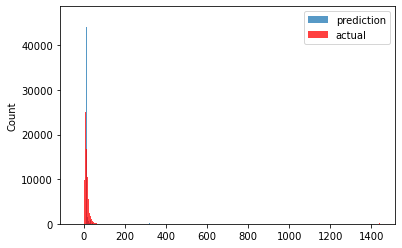

In [78]:
sns.histplot(y_train_pred, label='prediction')
sns.histplot(Y_train, label='actual',color='red')
plt.legend()